In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import sys
print(sys.version)
print(sys.path)
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2

import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid, save_image

from tensorboardX import SummaryWriter
from tqdm import tqdm
from copy import deepcopy


from utils import *
from models import *
from fid_score import *
from inception_score import *

from real_imgs import *

3.9.5 (v3.9.5:0a7dcbdb13, May  3 2021, 13:17:02) 
[Clang 6.0 (clang-600.0.57)]
['/Users/ryomacmini/work/codes/MNIST_Calculator/calculator', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/vscode_datascience_helpers', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles', '/Users/ryomacmini/.vscode/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages', '/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/IPython/extensions', '/Users/ryomacmini/.ipython']


# ロードした画像の表示を試す。
(1)ローカルにある画像を表示すること<br>
(2)RGBではなくグレースケールにすること<br>
(3)28.28にreshapeすること→なぜかRGB最小が0にならなかったので、そもそも28pixで画像を準備<br>

PNG (28, 28) RGBA
((0, 255), (0, 255), (0, 255), (255, 255))
(255, 255, 255, 255)


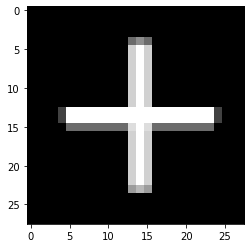

In [2]:
from PIL import Image, ImageFilter

im = Image.open('img/addition28pix.png')
plt.imshow(np.array(im))
print(im.format, im.size, im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(im.getextrema()) #RGB各色の最小値と最大値を取得。
print(im.getpixel((14,14 ))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

None (28, 28) L
(0, 255)
255


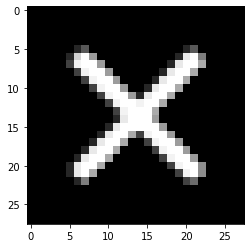

In [3]:
im2 = Image.open('img/multiplication28pix.png')
new_im = im2.convert('L')
plt.imshow(np.array(new_im), cmap='gray')
print(new_im.format, new_im.size, new_im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(new_im.getextrema()) #RGB各色の最小値と最大値を取得。
print(new_im.getpixel((14, 14))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

None (28, 28) L
(0, 255)
0


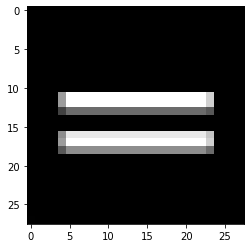

In [4]:
im3 = Image.open('img/equal28pix.png')
im3 = im3.convert('L')
im3 = im3.resize((28, 28))
plt.imshow(np.array(im3), cmap='gray')

print(im3.format, im3.size, im3.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(im3.getextrema()) #RGB各色の最小値と最大値を取得。
print(im3.getpixel((12, 10))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

### ＜参考＞resizeしたら、最小となっているところが"0"=完全黒にならなかった

None (28, 28) L
(12, 255)
255


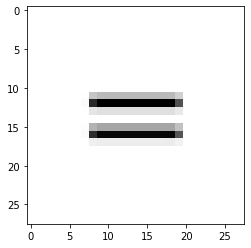

In [5]:
im4 = Image.open('img/equal.png')
im4 = im4.convert('L')
im4 = im4.resize((28, 28))
plt.imshow(np.array(im4), cmap='gray')

print(im4.format, im4.size, im4.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
#None (28, 28) L

print(im4.getextrema()) #RGB各色の最小値と最大値を取得。
#(12, 255)

print(im4.getpixel((1, 1))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。
#255

# MNISTから画像を表示してみる

### データをダウンロードする

In [6]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=len(trainset),shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

print(type(transform))
print(type(trainset))
print(type(testset))

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(type(trainset_not_transform))
print(type(testset_not_transform))


<class 'torchvision.transforms.transforms.Compose'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/.venv/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### trainloaderの中身を見る

In [7]:
data_iter = iter(trainloader)
images, labels = data_iter.next()

<built-in method type of Tensor object at 0x7f9de88549c0>
torch.Size([60000, 1, 28, 28])
60000
------------------------
<built-in method type of Tensor object at 0x7f9de8851500>
torch.Size([60000])
60000
------------------------
torch.Size([1, 28, 28])
------------------------
Label: tensor(5)


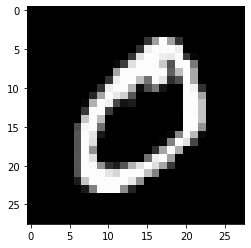

In [8]:
# matplotlibで1つ目のデータを可視化してみる
print(images.type)
print(images.size())
print(len(images))
print("------------------------")
print(labels.type)
print(labels.size())
print(len(labels))
print("------------------------")
print(images[1].size())
print("------------------------")
npimg = images[1].numpy()
npimg = npimg.reshape((28, 28))
plt.imshow(npimg, cmap='gray')
print('Label:', labels[0])

### testloaderの中身を見る

In [9]:
testloader_iter= iter(testloader)
images2, labels2 = testloader_iter.next()

<built-in method type of Tensor object at 0x7f9e19271700>
torch.Size([10000, 1, 28, 28])
10000
------------------------
<built-in method type of Tensor object at 0x7f9de8851780>
torch.Size([10000])
10000
------------------------
torch.Size([1, 28, 28])
------------------------
Label: tensor(7)


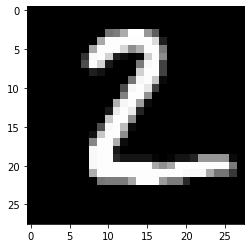

In [10]:
# matplotlibで1つ目のデータを可視化してみる
print(images2.type)
print(images2.size())
print(len(images2))
print("------------------------")
print(labels2.type)
print(labels2.size())
print(len(labels2))
print("------------------------")
print(images2[1].size())
print("------------------------")
npimg2 = images2[1].numpy()
npimg2 = npimg2.reshape((28, 28))
plt.imshow(npimg2, cmap='gray')
print('Label:', labels2[0])

# 試行錯誤

### 桁数をコントロールする方法をマスターする

In [11]:
X_digit = 1
Y_digit = 1

X = random.randrange(10**(X_digit-1),10**X_digit) #指定の桁数の中で乱数が出る
Y = random.randrange(10**(Y_digit-1),10**Y_digit) #指定の桁数の中で乱数が出る
Z = X*Y

print(X,Y,Z)
print('Xの桁数は',len(str(X)),\
      'Yの桁数は',len(str(Y)),\
      'Zの桁数は',len(str(Z)))

1 5 5
Xの桁数は 1 Yの桁数は 1 Zの桁数は 1


※pythonのパディングという操作があるよ！

### 数字を指定すれば、指定の画像が取ってこれるようになろう

In [12]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=len(trainset),shuffle=False,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),shuffle=False, num_workers=2)

classes = tuple(np.linspace(0, 9, 10, dtype=np.uint8))

print(type(transform))
print(type(trainset))
print(type(testset))

trainset_not_transform = torchvision.datasets.MNIST(root='./data', train=True,download=True)
testset_not_transform = torchvision.datasets.MNIST(root='./data', train=False, download=True)
print(type(trainset_not_transform))
print(type(testset_not_transform))

trainloader_iter = iter(trainloader)
train_images, train_labels = trainloader_iter.next()


<class 'torchvision.transforms.transforms.Compose'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>
<class 'torchvision.datasets.mnist.MNIST'>


In [13]:
MNIST_dict = {i: [] for i in range(10)}
MNIST_dict

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [14]:
for i in range(len(train_images)):
    if train_labels[i] == 0:
        MNIST_dict[0].append(train_images[i])
    if train_labels[i] == 1:
        MNIST_dict[1].append(train_images[i])
    if train_labels[i] == 2:
        MNIST_dict[2].append(train_images[i])
    if train_labels[i] == 3:
        MNIST_dict[3].append(train_images[i])
    if train_labels[i] == 4:
        MNIST_dict[4].append(train_images[i])
    if train_labels[i] == 5:
        MNIST_dict[5].append(train_images[i])
    if train_labels[i] == 6:
        MNIST_dict[6].append(train_images[i])
    if train_labels[i] == 7:
        MNIST_dict[7].append(train_images[i])
    if train_labels[i] == 8:
        MNIST_dict[8].append(train_images[i])
    if train_labels[i] == 9:
        MNIST_dict[9].append(train_images[i])

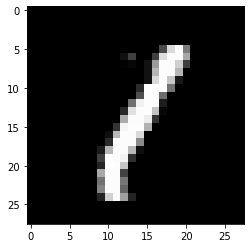

In [15]:
test1 = MNIST_dict[1][1000].numpy()
test1 = test1.reshape((28, 28))
plt.imshow(test1, cmap='gray')

In [16]:
print(len(MNIST_dict[0]))
print(len(MNIST_dict[1]))
print(len(MNIST_dict[2]))
print(len(MNIST_dict[3]))
print(len(MNIST_dict[4]))
print(len(MNIST_dict[5]))
print(len(MNIST_dict[6]))
print(len(MNIST_dict[7]))
print(len(MNIST_dict[8]))
print(len(MNIST_dict[9]))

5923
6742
5958
6131
5842
5421
5918
6265
5851
5949


### ランダムに画像を指定して持ってくる

In [17]:
def random_get(figure):
    random_num = random.randrange(len(MNIST_dict[figure]))
    random_get = MNIST_dict[figure][random_num].numpy()
    random_get = random_get.reshape((28, 28))
    plt.imshow(random_get, cmap='gray')
    print('生成した画像番号は',random_num)


生成した画像番号は 2220


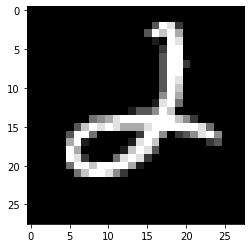

In [18]:
random_get(2)

None (28, 28) L
(0, 255)
255


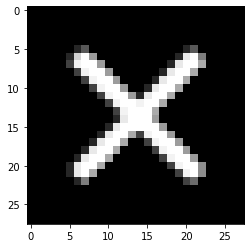

In [19]:
im2 = Image.open('img/multiplication28pix.png')
new_im = im2.convert('L')
plt.imshow(np.array(new_im), cmap='gray')
print(new_im.format, new_im.size, new_im.mode) #フォーマット、サイズ（幅、高さ）、モードなどのメタ情報を取得。サイズは(幅, 高さ)。
print(new_im.getextrema()) #RGB各色の最小値と最大値を取得。
print(new_im.getpixel((14, 14))) #指定した座標の色を取得。座標の原点(0, 0)は左上。(R, G, B)のタプルが返される。

### 画像を取得し、Tensorへ変換する

In [20]:
img1 = Image.open('img/multiplication28pix.png')
img1_tensor = torchvision.transforms.functional.to_tensor(img1)
print(img1_tensor)
# plt.imshow(np.array(img1), cmap='gray')

img2 = Image.open('img/addition28pix.jpg')
img2_tensor = torchvision.transforms.functional.to_tensor(img2)
print(img2_tensor)
# plt.imshow(np.array(img2), cmap='gray')

img3 = Image.open('img/equal28pix.jpg')
img3_tensor = torchvision.transforms.functional.to_tensor(img3)
print(img3_tensor)
# plt.imshow(np.array(img3), cmap='gray')

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 

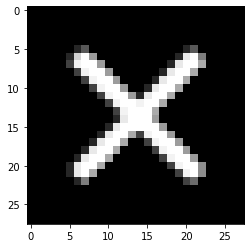

In [21]:
plt.imshow(img1_tensor[0],cmap="gray")
plt.savefig("test.png")

### Tensorから画像に戻してみる

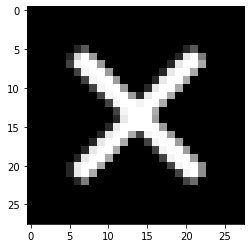

In [22]:
img1_PIL = torchvision.transforms.functional.to_pil_image(img1_tensor)
# img1_PIL.show
plt.imshow(img1_PIL, cmap='gray')

### Tensorを画像として保存する

2つとも試したけどだめだった。エラーは同じ。
```
torchvision.utils.save_image(img3_tensor,'img_tensor3.jpg')　←　tensorをtorchvisionを使って画像化
img1_PIL.save("img1_PIL.jpg","JPEG",quality=95)　← PILをつかって、JPEGを保存する

OSError: cannot write mode RGBA as JPEG
```

結論、.pngを読み込むと、TensorがRGBAになってしまい、各ライブラリの保存形式では保存ができないということが起きた。


In [23]:
#どっちでも行けるんだけど、PILよりtorchvisionで出来る方を採用しよう。
# img1_PIL.save("img1_PIL.jpg","JPEG")
torchvision.utils.save_image(img3_tensor,'train_img/img_tensor3.jpg')

ちなみにPNGで取得しても、後でRGB変換をすれば、上記save機能で保存出来る。
```
from PIL import Image
img1_PIL = img1_PIL.convert("RGB")
img1_PIL.save("img1_PIL.jpg","JPEG",quality=95)
```

## 次はここから！！！！
やること：<br>
●乱数を指定し、画像を取ってくる。seedな方が良いかもしれない。←done<br> 
●指定の数字の画像を取ってこれるようにするはX_digitとする。 ←できたも同然<br>
●画像を横向きでくっつける <br> 
●画像を保存できるようにする ←done　<br>
○指定のGoogleDriveのディレクトリに画像を保存する

### 画像を横方向にくっつけていく
参考文献：https://roshiago.blog.ss-blog.jp/2019-07-15　<br>
https://note.nkmk.me/python-opencv-hconcat-vconcat-np-tile/<br>
<br>
Pillowでも出来そうだったんだけど、concatみたいな便利なメソッドは無さそうで<br>
1つの大きな画像を作って、そこに上から位置を決めてペーストしていく、っていう面倒な感じに見えたからやめた<br>

In [24]:
img1 = Image.open('img/multiplication28pix.jpg')
img1 = np.array(img1)

img2 = Image.open('img/addition28pix.jpg')
img2 = np.array(img2)

img3 = Image.open('img/equal28pix.jpg')
img3 = np.array(img3)

im_list = [img1,img2,img3]

In [25]:
img123_hconcat = cv2.hconcat(im_list)
cv2.imwrite('train_img/img123_hconcat.jpg', img123_hconcat)

True

### 指定の画像をgoogle driveへ保存する
クライアントID：698980364619-aj0j55fddsknbmscqo5asdq1sk73g821.apps.googleusercontent.com<br>
クライアントシークレット：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


### スクリプトから使うときは、OAuthIDのアプリケーションの種類は「デスクトップアプリ」
698980364619-bqpmu3vd8tsq23n3jrt5lbbv00kehe7l.apps.googleusercontent.com
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

In [42]:
%cd /Users/ryomacmini/work/codes/MNIST_Calculator/calculator/drive

/Users/ryomacmini/work/codes/MNIST_Calculator/calculator/drive


In [86]:
%run imageupload.py

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?client_id=698980364619-aj0j55fddsknbmscqo5asdq1sk73g821.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8090%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code

Authentication successful.
GoogleDriveFile({'title': 'test.png', 'mimeType': 'image/png', 'parents': ['1NyB0TBcwtJm3xi9DIEV-Ty9UmVX0Gisc']})
